# __Data visualisation__

In [5]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_pickle('../data/marginal_emissions_dtindex1.pkl')
df.head()

,t CO2-e / MWh
DateTime,
2018-06-01 03:55:00,0.912643
2018-06-01 03:50:00,0.912643
2018-06-01 03:45:00,0.912643
2018-06-01 03:40:00,0.912643
2018-06-01 03:35:00,0.912643


In [7]:
df.isnull().any()

t CO2-e / MWh    False
dtype: bool

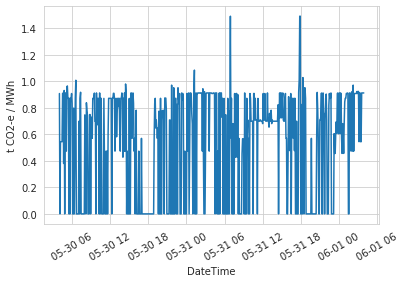

In [9]:
import matplotlib.dates as mdates

fig = sns.lineplot(df.index[:576], df['t CO2-e / MWh'].iloc[:576])
fig.set_ylabel("t CO2-e / MWh")


fig.format_xdata = mdates.DateFormatter('%Y-%m-%d')

for i in fig.get_xticklabels():
    i.set_rotation(30)

sns.set_style("whitegrid")

#pip install --upgrade numpy pandas matplotlib seaborn jupyterlab

In [ ]:
fig = plt.plot_date(df_resample.index[:576], df_resample.CO2E_EMISSIONS_FACTOR.iloc[:576], linestyle='solid', marker=None)

plt.xlabel("Year", labelpad=15, fontsize=15, fontweight='bold')
plt.ylabel("t CO2-e / MWh", labelpad=15, fontsize=15, fontweight='bold')

sns.set_style('whitegrid')
plt.style.use('seaborn')